# SCENIC Testing

**Authorship:**
Adam Klie, *02/16/2022*
***
**Description:**
Notebook to generate SCENIC test data, run the SCENIC pipeline and perform Jupyter Notebook analysis of SCENIC results
***
**TODOs:**
 - <font color='green'> Done TODO </font>
 - <font color='orange'> WIP TODO </font>
 - <font color='red'> Queued TODO </font>
***

# Set-up

In [2]:
# The classics
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
np.random.seed(13)

# Single cell
import scanpy as sc
sc.logging.print_header()
sc.set_figure_params(dpi=150, fontsize=10, dpi_save=600)
sc.settings.njobs = 16
sc.settings.verbosity = 3 

# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
%autoreload 2

scanpy==1.7.2 anndata==0.7.8 umap==0.5.2 numpy==1.19.5 scipy==1.5.3 pandas==1.1.5 scikit-learn==0.23.2 statsmodels==0.12.2 python-igraph==0.9.1 louvain==0.7.0


# Load pbmc10k data

In [4]:
adata = sc.read_10x_mtx("/cellar/users/aklie/data/single_cell/gex/pbmc_10k_v3/filtered_feature_bc_matrix/", cache=True)

... writing an h5ad cache file to speedup reading next time


# Summarize the data

In [5]:
nCountsPerGene = np.sum(adata.X, axis=0)
nCellsPerGene = np.sum(adata.X>0, axis=0)

# Show info
print("Number of counts (in the dataset units) per gene:", nCountsPerGene.min(), " - " ,nCountsPerGene.max())
print("Number of cells in which each gene is detected:", nCellsPerGene.min(), " - " ,nCellsPerGene.max())

Number of counts (in the dataset units) per gene: 0.0  -  3567008.0
Number of cells in which each gene is detected: 0  -  11766


In [6]:
nCells=adata.X.shape[0]

# pySCENIC thresholds
minCountsPerGene=3*.01*nCells # 3 counts in 1% of cells
print("minCountsPerGene: ", minCountsPerGene)

minSamples=.01*nCells # 1% of cells
print("minSamples: ", minSamples)

minCountsPerGene:  353.07
minSamples:  117.69


In [7]:
# simply compute the number of genes per cell (computers 'n_genes' column)
sc.pp.filter_cells(adata, min_genes=0)
# mito and genes/counts cuts
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

/cellar/users/aklie/opt/miniconda3/envs/single_cell_py/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/cellar/users/aklie/opt/miniconda3/envs/single_cell_py/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/cellar/users/aklie/opt/miniconda3/envs/single_cell_py/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Plea

Text(0.5, 0.0, 'Genes expressed per cell')

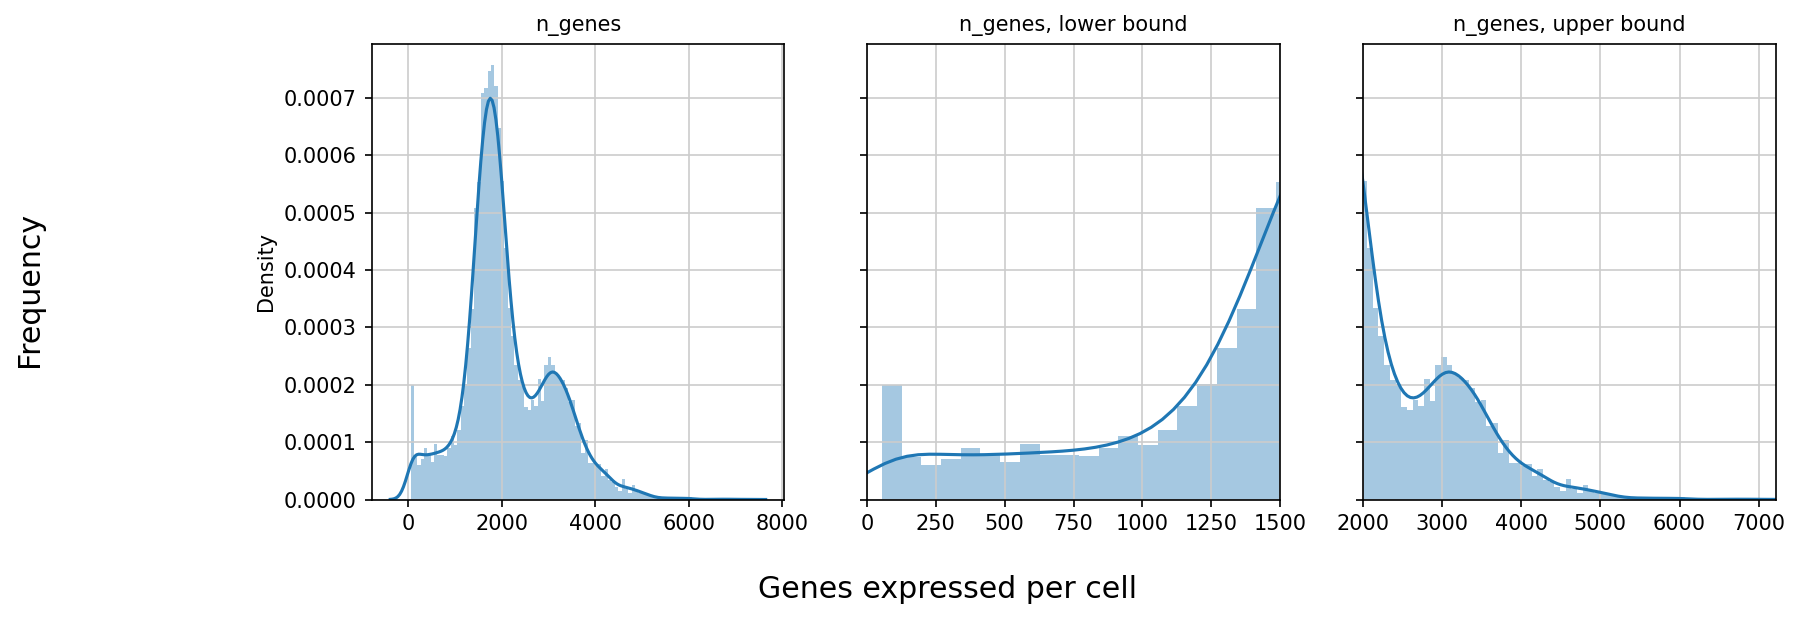

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=True)

x = adata.obs['n_genes']
x_lowerbound = 1500
x_upperbound = 2000
nbins=100

sns.distplot(x, ax=ax1, norm_hist=True, bins=nbins)
sns.distplot(x, ax=ax2, norm_hist=True, bins=nbins)
sns.distplot(x, ax=ax3, norm_hist=True, bins=nbins)

ax2.set_xlim(0,x_lowerbound)
ax3.set_xlim(x_upperbound, adata.obs['n_genes'].max() )

for ax in (ax1,ax2,ax3): 
    ax.set_xlabel('')

ax1.title.set_text('n_genes')
ax2.title.set_text('n_genes, lower bound')
ax3.title.set_text('n_genes, upper bound')

fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='x-large')
fig.text(0.5, 0.0, 'Genes expressed per cell', ha='center', va='center', size='x-large')

/cellar/users/aklie/opt/miniconda3/envs/single_cell_py/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/cellar/users/aklie/opt/miniconda3/envs/single_cell_py/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/cellar/users/aklie/opt/miniconda3/envs/single_cell_py/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Plea

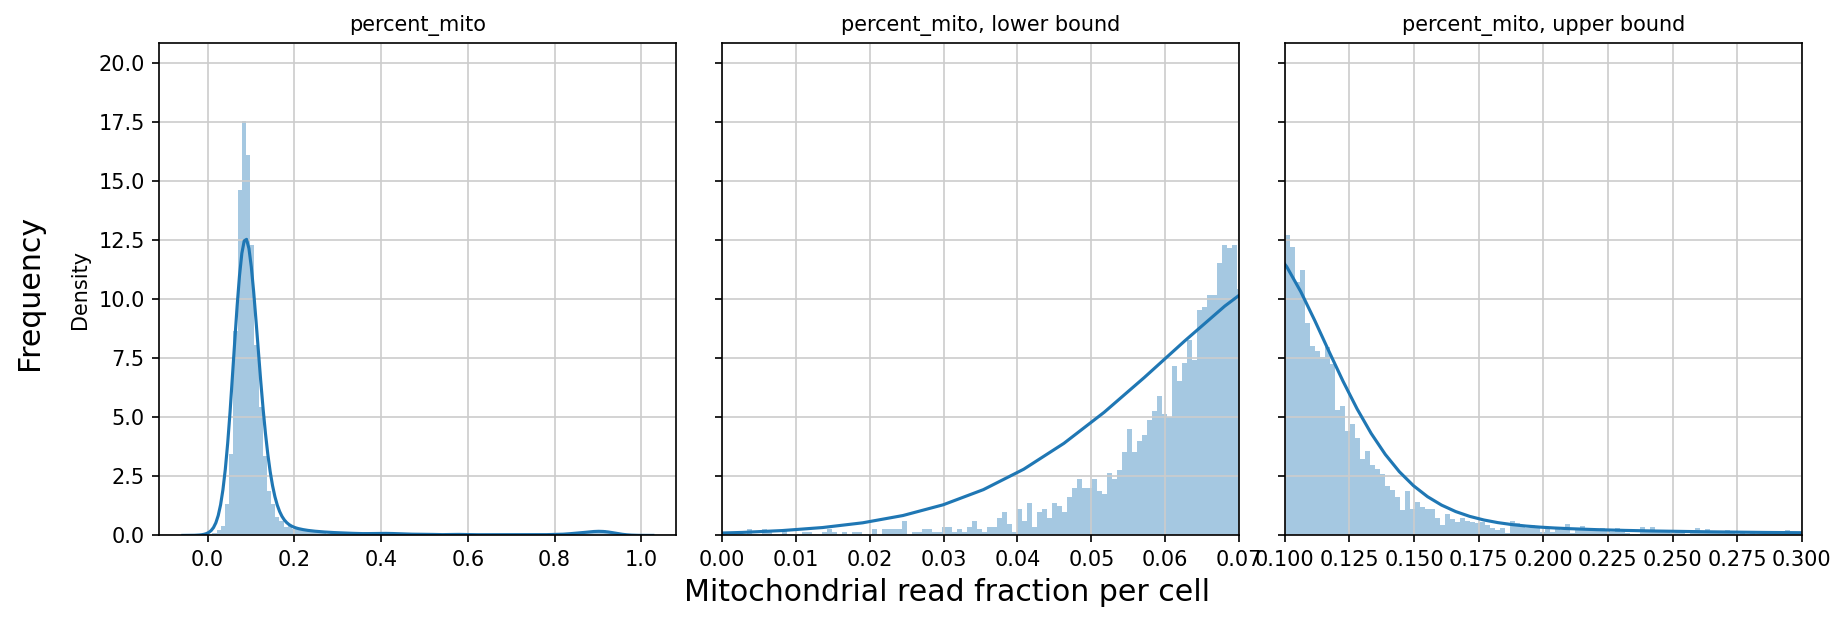

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=True)

x = adata.obs['percent_mito']
x_lowerbound = [0.0, 0.07 ]
x_upperbound = [ 0.10, 0.3 ]
nbins=100

sns.distplot(x, ax=ax1, norm_hist=True, bins=nbins)
sns.distplot(x, ax=ax2, norm_hist=True, bins=int(nbins/(x_lowerbound[1]-x_lowerbound[0])) )
sns.distplot(x, ax=ax3, norm_hist=True, bins=int(nbins/(x_upperbound[1]-x_upperbound[0])) )

ax2.set_xlim(x_lowerbound[0], x_lowerbound[1])
ax3.set_xlim(x_upperbound[0], x_upperbound[1] )
for ax in (ax1,ax2,ax3): 
    ax.set_xlabel('')

ax1.title.set_text('percent_mito')
ax2.title.set_text('percent_mito, lower bound')
ax3.title.set_text('percent_mito, upper bound')

fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='x-large')
fig.text(0.5, 0.0, 'Mitochondrial read fraction per cell', ha='center', va='center', size='x-large')

fig.tight_layout()

/cellar/users/aklie/opt/miniconda3/envs/single_cell_py/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/cellar/users/aklie/opt/miniconda3/envs/single_cell_py/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/cellar/users/aklie/opt/miniconda3/envs/single_cell_py/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Plea

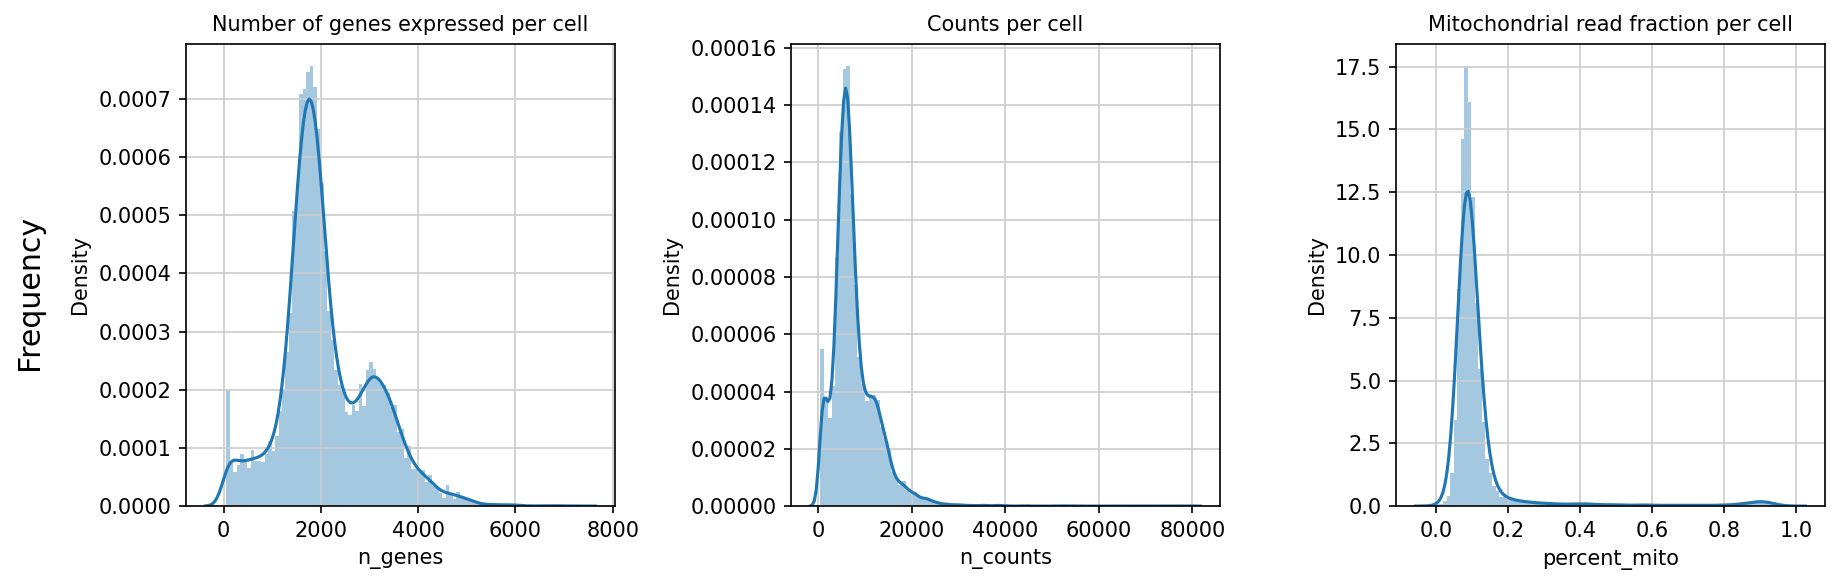

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=False)

sns.distplot( adata.obs['n_genes'], ax=ax1, norm_hist=True, bins=100)
sns.distplot( adata.obs['n_counts'], ax=ax2, norm_hist=True, bins=100)
sns.distplot( adata.obs['percent_mito'], ax=ax3, norm_hist=True, bins=100)

ax1.title.set_text('Number of genes expressed per cell')
ax2.title.set_text('Counts per cell')
ax3.title.set_text('Mitochondrial read fraction per cell')

fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='x-large')

fig.tight_layout()

... storing 'feature_types' as categorical


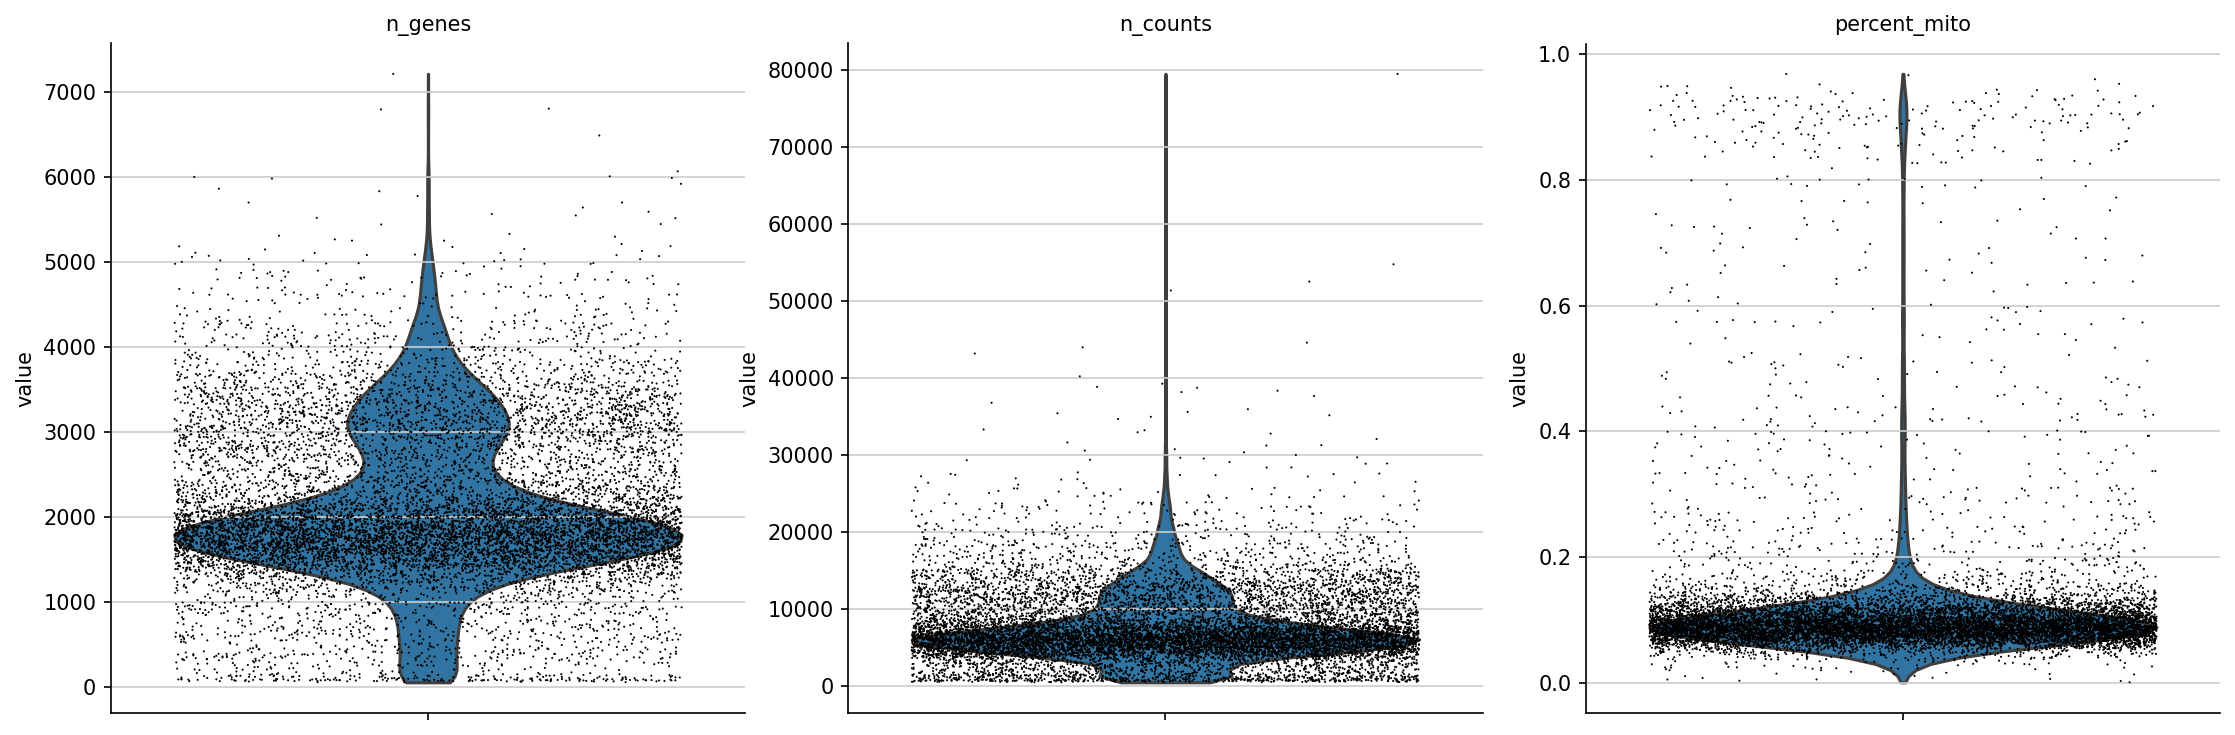

In [11]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
    jitter=0.4, multi_panel=True )

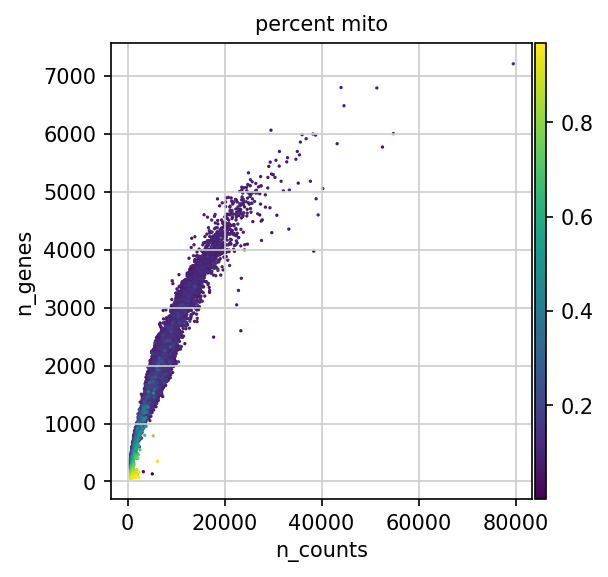

In [12]:
sc.pl.scatter(adata, x='n_counts', y='n_genes', color='percent_mito')

# Filtering
Description

In [13]:
# initial cuts
sc.pp.filter_cells(adata, min_genes=200 )
sc.pp.filter_genes(adata, min_cells=3 )

filtered out 232 cells that have less than 200 genes expressed
filtered out 13246 genes that are detected in less than 3 cells


In [14]:
adata = adata[adata.obs['n_genes'] < 4000, :]
adata = adata[adata.obs['percent_mito'] < 0.15, :]

/cellar/users/aklie/opt/miniconda3/envs/single_cell_py/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/cellar/users/aklie/opt/miniconda3/envs/single_cell_py/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/cellar/users/aklie/opt/miniconda3/envs/single_cell_py/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Plea

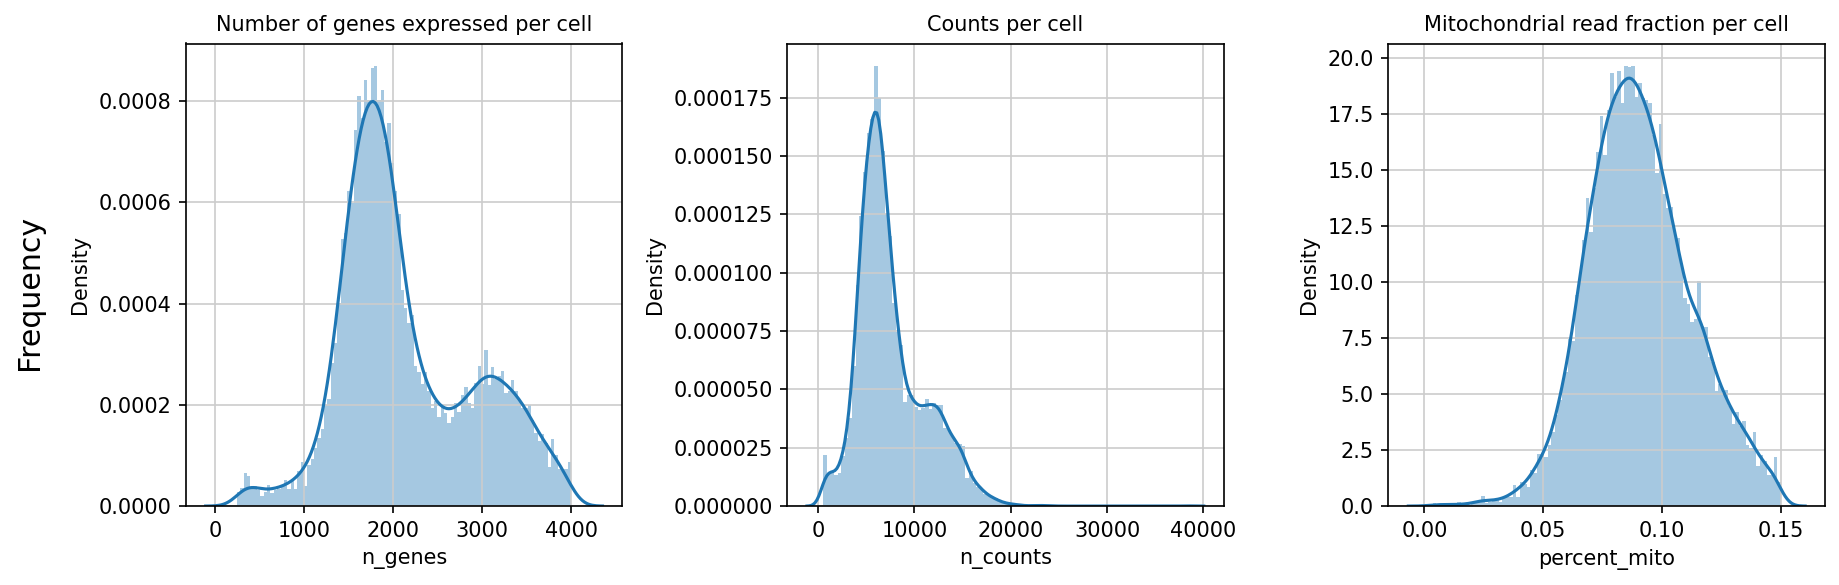

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=False)

adata.obs['n_genes']

sns.distplot( adata.obs['n_genes'], ax=ax1, norm_hist=True, bins=100)
sns.distplot( adata.obs['n_counts'], ax=ax2, norm_hist=True, bins=100)
sns.distplot( adata.obs['percent_mito'], ax=ax3, norm_hist=True, bins=100)

ax1.title.set_text('Number of genes expressed per cell')
ax2.title.set_text('Counts per cell')
ax3.title.set_text('Mitochondrial read fraction per cell')

fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='x-large')

fig.tight_layout()

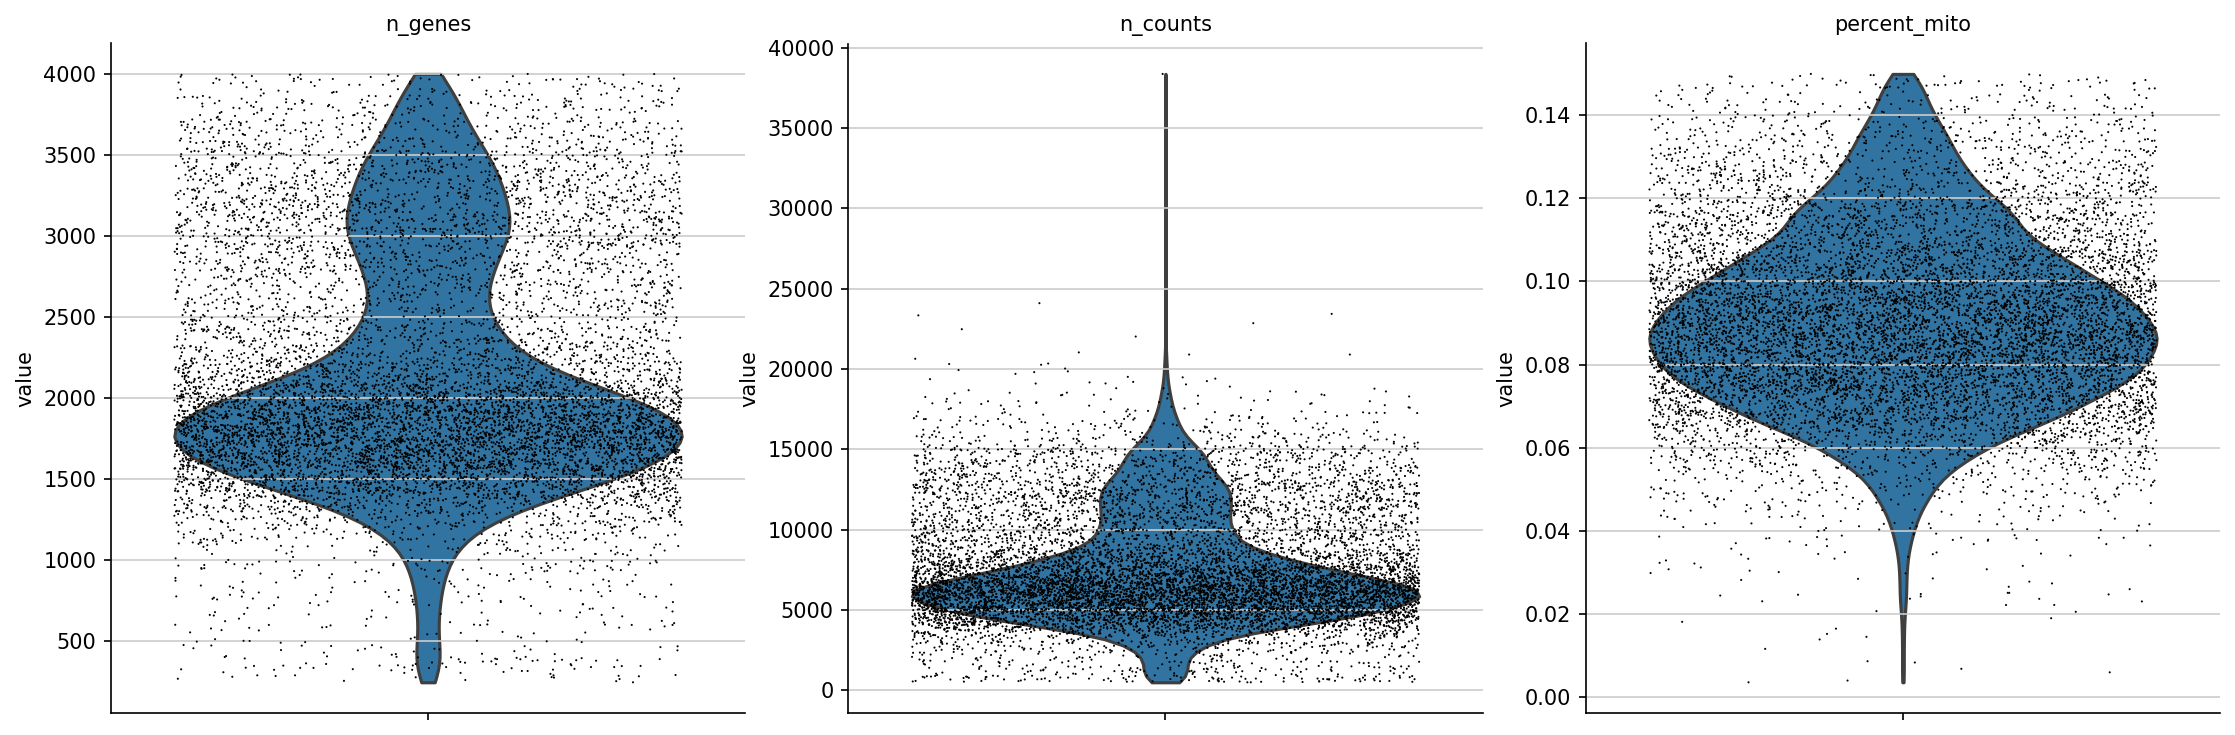

In [16]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
    jitter=0.4, multi_panel=True )

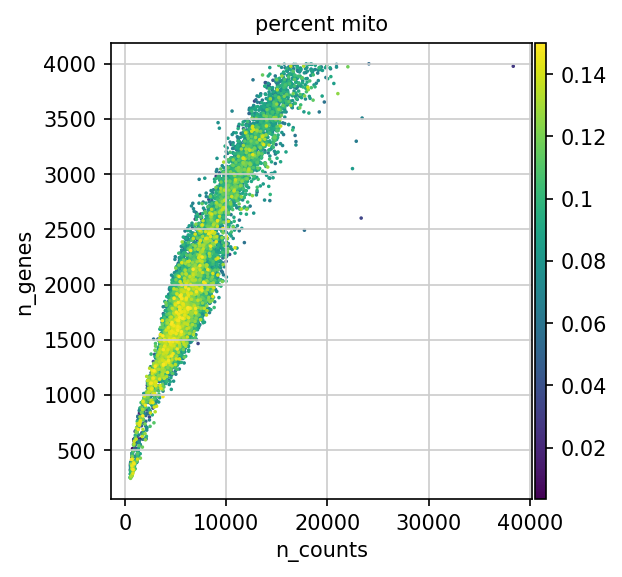

In [17]:
sc.pl.scatter(adata, x='n_counts', y='n_genes', color='percent_mito')

In [20]:
import loompy as lp
# create basic row and column attributes for the loom file:
row_attrs = {
    "Gene": np.array(adata.var_names) ,
}
col_attrs = {
    "CellID": np.array(adata.obs_names) ,
    "nGene": np.array( np.sum(adata.X.transpose()>0 , axis=0)).flatten() ,
    "nUMI": np.array( np.sum(adata.X.transpose() , axis=0)).flatten() ,
}
lp.create( "pbmc10k_filtered_scenic.loom", adata.X.transpose(), row_attrs, col_attrs)

# Subset

In [ ]:
adata_subset = sc.pp.subsample(adata, n_obs=100, random_state=13, copy=True)

In [ ]:
rand_genes = np.random.choice(adata_subset.var.index, size=500)

In [ ]:
adata_subset = adata_subset[:, rand_genes]

In [ ]:
from arboreto.utils import load_tf_names

In [ ]:
tf_names = load_tf_names("../hs_hgnc_tfs.txt")

In [144]:
tfs = np.random.choice(adata_subset.var.index[adata_subset.var.index.isin(tf_names)], size=25)

In [146]:
np.savetxt("25_tfs.txt", tfs, fmt="%s")

In [147]:
import loompy as lp
# create basic row and column attributes for the loom file:
row_attrs = {
    "Gene": np.array(adata_subset.var_names) ,
}
col_attrs = {
    "CellID": np.array(adata_subset.obs_names) ,
    "nGene": np.array( np.sum(adata_subset.X.transpose()>0 , axis=0)).flatten() ,
    "nUMI": np.array( np.sum(adata_subset.X.transpose() , axis=0)).flatten() ,
}
lp.create( "pbmc10k_filtered_subset_scenic.loom", adata_subset.X.transpose(), row_attrs, col_attrs)

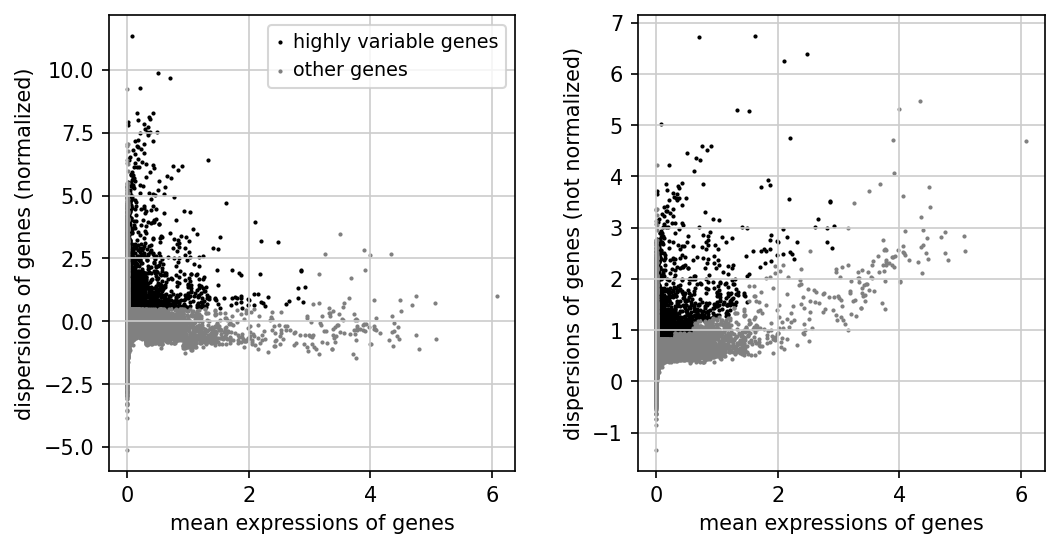

In [55]:
# save a copy of the raw data
adata.raw = adata

# Total-count normalize (library-size correct) to 10,000 reads/cell
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

# log transform the data.
sc.pp.log1p(adata)

# identify highly variable genes.
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

# keep only highly variable genes:
adata = adata[:, adata.var['highly_variable']]

# regress out total counts per cell and the percentage of mitochondrial genes expressed
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'] ) #, n_jobs=args.threads)

# scale each gene to unit variance, clip values exceeding SD 10.
sc.pp.scale(adata, max_value=10)

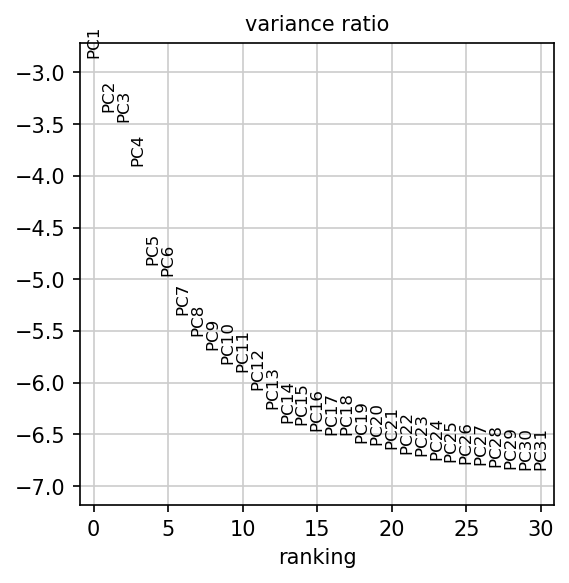

In [56]:
# principal component analysis
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)

In [65]:
from MulticoreTSNE import MulticoreTSNE as TSNE

In [66]:
# neighborhood graph of cells (determine optimal number of PCs here)
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30)
# compute UMAP
sc.tl.umap(adata)
# tSNE
tsne = TSNE( n_jobs=20 )
adata.obsm['X_tsne'] = tsne.fit_transform( adata.X )

KeyboardInterrupt: 

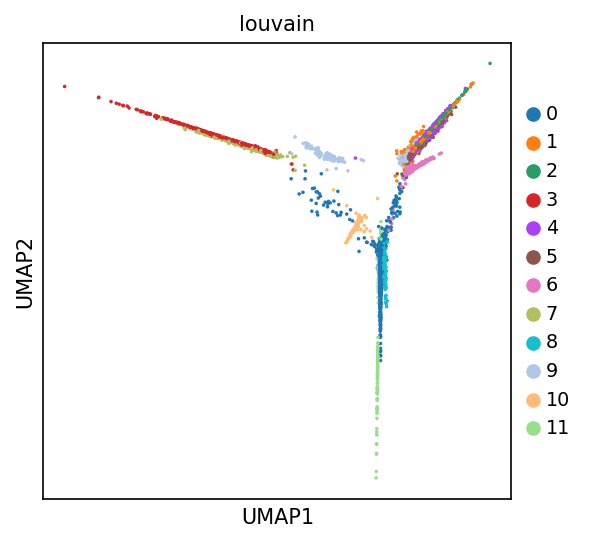

In [64]:
# cluster the neighbourhood graph
sc.tl.louvain(adata,resolution=0.4)

sc.pl.umap(adata, color=['louvain'] )

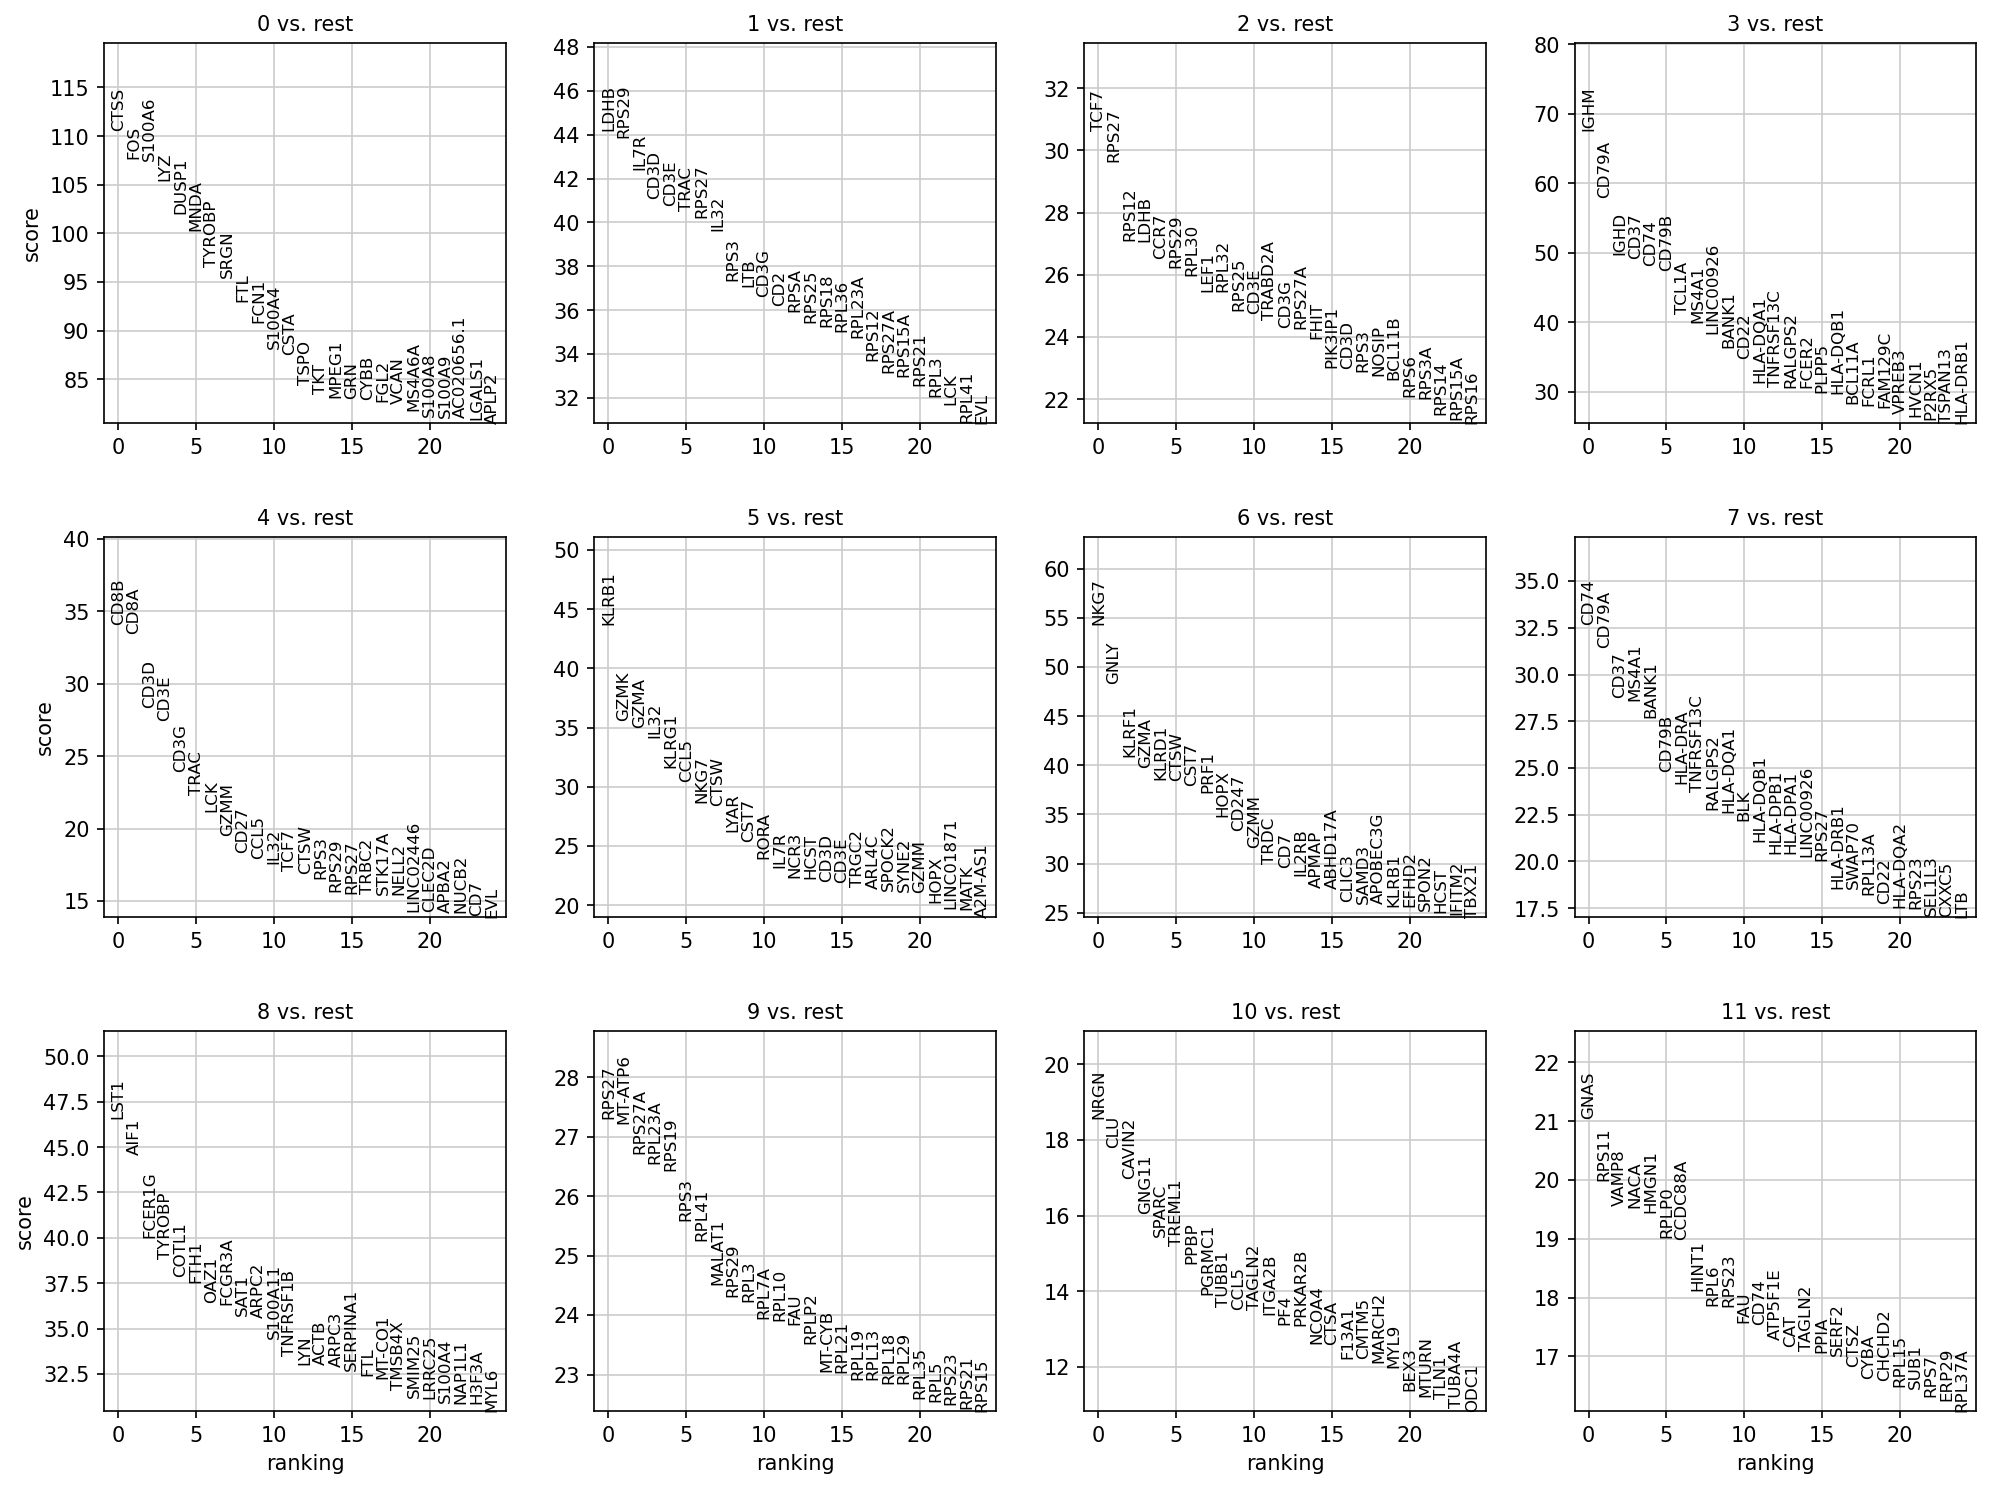

,0,1,2,3,4,5,6,7,8,9,10,11
0,CTSS,LDHB,TCF7,IGHM,CD8B,KLRB1,NKG7,CD74,LST1,RPS27,NRGN,GNAS
1,FOS,RPS29,RPS27,CD79A,CD8A,GZMK,GNLY,CD79A,AIF1,MT-ATP6,CLU,RPS11
2,S100A6,IL7R,RPS12,IGHD,CD3D,GZMA,KLRF1,CD37,FCER1G,RPS27A,CAVIN2,VAMP8
3,LYZ,CD3D,LDHB,CD37,CD3E,IL32,GZMA,MS4A1,TYROBP,RPL23A,GNG11,NACA
4,DUSP1,CD3E,CCR7,CD74,CD3G,KLRG1,KLRD1,BANK1,COTL1,RPS19,SPARC,HMGN1
5,MNDA,TRAC,RPS29,CD79B,TRAC,CCL5,CTSW,CD79B,FTH1,RPS3,TREML1,RPLP0
6,TYROBP,RPS27,RPL30,TCL1A,LCK,NKG7,CST7,HLA-DRA,OAZ1,RPL41,PPBP,CCDC88A
7,SRGN,IL32,LEF1,MS4A1,GZMM,CTSW,PRF1,TNFRSF13C,FCGR3A,MALAT1,PGRMC1,HINT1
8,FTL,RPS3,RPL32,LINC00926,CD27,LYAR,HOPX,RALGPS2,SAT1,RPS29,TUBB1,RPL6
9,FCN1,LTB,RPS25,BANK1,CCL5,CST7,CD247,HLA-DQA1,ARPC2,RPL3,CCL5,RPS23


In [67]:
# find marker genes
sc.tl.rank_genes_groups(adata, 'louvain', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

# sc.tl.rank_genes_groups(adata, 'louvain', method='logreg')
# sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(10)

In [ ]:
import loompy as lp
# create basic row and column attributes for the loom file:
row_attrs = {
    "Gene": np.array(adata.var_names) ,
}
col_attrs = {
    "CellID": np.array(adata.obs_names) ,
    "nGene": np.array( np.sum(adata.X.transpose()>0 , axis=0)).flatten() ,
    "nUMI": np.array( np.sum(adata.X.transpose() , axis=0)).flatten() ,
}
lp.create("pbmc10k_filtered_scenic.loom", adata.X.transpose(), row_attrs, col_attrs)

# SCENIC

STEP 1: Gene regulatory network inference, and generation of co-expression modules
Phase Ia: GRN inference using the GRNBoost2 algorithm
For this step the CLI version of SCENIC is used. This step can be deployed on an High Performance Computing system. We use the counts matrix (without log transformation or further processing) from the loom file we wrote earlier. Output: List of adjacencies between a TF and its targets stored in ADJACENCIES_FNAME.

In [151]:
%%bash
source activate single_cell_py
pyscenic grn pbmc10k_filtered_subset_scenic.loom 25_tfs.txt -o adj.tsv --num_workers 16

preparing dask client
parsing input
creating dask graph
16 partitions
computing dask graph
not shutting down client, client was created externally
finished



2022-02-16 16:46:33,091 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2022-02-16 16:46:33,240 - pyscenic.cli.pyscenic - INFO - Inferring regulatory networks.

2022-02-16 16:48:10,239 - pyscenic.cli.pyscenic - INFO - Writing results to file.


STEP 2-3: Regulon prediction aka cisTarget from CLI
For this step the CLI version of SCENIC is used. This step can be deployed on an High Performance Computing system.

Output: List of adjacencies between a TF and its targets stored in MOTIFS_FNAME.

locations for ranking databases, and motif annotations:

In [155]:
%%bash
source activate single_cell_py
pyscenic ctx adj.tsv \
    ../hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.feather \
    --annotations_fname ../motifs-v9-nr.hgnc-m0.001-o0.0.tbl \
    --expression_mtx_fname pbmc10k_filtered_scenic.loom \
    --output reg.csv \
    --mask_dropouts \
    --num_workers 16

[########################################] | 100% Completed | 44.6s



2022-02-16 16:56:07,341 - pyscenic.cli.pyscenic - INFO - Creating modules.

2022-02-16 16:56:07,354 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2022-02-16 16:56:12,765 - pyscenic.utils - INFO - Calculating Pearson correlations.

2022-02-16 16:56:12,769 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [True].

2022-02-16 16:56:13,096 - pyscenic.utils - INFO - Creating modules.

2022-02-16 16:56:14,248 - pyscenic.cli.pyscenic - IN

STEP 4: Cellular enrichment (aka AUCell) from CLI
It is important to check that most cells have a substantial fraction of expressed/detected genes in the calculation of the AUC. The following histogram gives an idea of the distribution and allows selection of an appropriate threshold. In this plot, a few thresholds are highlighted, with the number of genes selected shown in red text and the corresponding percentile in parentheses). See the relevant section in the R tutorial for more information.

By using the default setting for --auc_threshold of 0.05, we see that 1192 genes are selected for the rankings based on the plot below.

In [156]:
%%bash
source activate single_cell_py
pyscenic aucell \
    pbmc10k_filtered_scenic.loom \
    reg.csv \
    --output pyscenic_output.loom \
    --num_workers 20

Create regulons from a dataframe of enriched features.
Additional columns saved: []



2022-02-16 16:59:46,516 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2022-02-16 16:59:52,708 - pyscenic.cli.pyscenic - INFO - Loading gene signatures.

2022-02-16 16:59:52,778 - pyscenic.cli.pyscenic - INFO - Calculating cellular enrichment.

2022-02-16 17:00:02,294 - pyscenic.cli.pyscenic - INFO - Writing results to file.


In [157]:
import json
import zlib
import base64

# collect SCENIC AUCell output
lf = lp.connect("pyscenic_output.loom" , mode='r+', validate=False )
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)
lf.close()

In [160]:
import umap

# UMAP
runUmap = umap.UMAP(n_neighbors=10, min_dist=0.4, metric='correlation').fit_transform
dr_umap = runUmap( auc_mtx )
#pd.DataFrame(dr_umap, columns=['X', 'Y'], index=auc_mtx.index).to_csv( "scenic_umap.txt", sep='\t')

In [161]:
dr_umap

array([[  3.6948857,  14.6852255],
       [ -9.382854 ,   6.4025364],
       [ 14.163157 , -11.528371 ],
       ...,
       [  1.9638705,  -9.332168 ],
       [ 14.778394 ,   3.3326547],
       [ 19.86517  ,   6.7104535]], dtype=float32)

In [159]:
# tSNE
tsne = TSNE( n_jobs=20 )
dr_tsne = tsne.fit_transform( auc_mtx )
#pd.DataFrame(dr_tsne, columns=['X', 'Y'], index=auc_mtx.index).to_csv( "scenic_tsne.txt", sep='\t')

KeyboardInterrupt: 

# Scratch
Place for old or testing code

# References